# ML

## 1) Data

In [25]:
import pandas as pd 
import numpy as np
pd.set_option('display.max_columns', 500)
import torch
from torch.utils.data import DataLoader, TensorDataset

In [26]:
df = pd.read_csv('../data/datastep2.csv')
df['datetime'] = pd.to_datetime(df['datetime'], format = '%Y%m%d%H%M')
# df = df[df.id == 'KORD'] #chad only KORD
df.set_index(['datetime', 'id'], inplace=True)
df.sort_index(inplace=True)

In [29]:
day_extend = 5
feat_cols = ['temp']
train_years = [2018, 2019, 2020, 2021, 2022]
val_years = [2023]
test_years = [2024, 2025]
train_X_ls = []
val_X_ls = []
test_X_ls = []
train_y_ls = []
val_y_ls = []
test_y_ls = []
test_Z_ls = []

# T = len(df)
T = len(df)
terminate_date = pd.to_datetime('2025-03-21')
## while loop till end
for i in range(0, T, 12):
    if i % 120_000 == 0: print(i)
    day_in = df.index[i][0]
    if day_in > terminate_date: break 
    day_out = day_in + pd.Timedelta(days=day_extend)
    day_out_out = day_out + pd.Timedelta(days=day_extend)
    obj = df.loc[(slice(day_in, day_out))]
    obj_X = obj[feat_cols].ffill().bfill()
    if len(obj_X) != (day_extend*24+1)*30: #30 ids *30 usually
        continue

    obj2 = df.loc[(slice(day_in, day_out_out))]
    ts_out_out = obj2.index[-1][0]

    try:
        obj_Y = obj2.loc[(ts_out_out, 'KORD')].temp
    except:
        continue

    if np.isnan(obj_Y):
        continue

    if day_in.year in train_years: train_X_ls.append(obj_X.values), train_y_ls.append(obj_Y)
    elif day_in.year in val_years: val_X_ls.append(obj_X.values), val_y_ls.append(obj_Y)
    elif day_in.year in test_years: test_X_ls.append(obj_X.values), test_y_ls.append(obj_Y), test_Z_ls.append(obj_X.reset_index())
    else: raise ValueError(f"year unknown: {day_in.year}")

train_X_np, val_X_np, test_X_np = np.array(train_X_ls), np.array(val_X_ls), np.array(test_X_ls)
train_y_np, val_y_np, test_y_np = np.array(train_y_ls), np.array(val_y_ls), np.array(test_y_ls)

train_X_t, val_X_t, test_X_t = torch.tensor(train_X_np, dtype=torch.float32), torch.tensor(val_X_np, dtype=torch.float32), torch.tensor(test_X_np, dtype=torch.float32)
train_y_t, val_y_t, test_y_t = torch.tensor(train_y_np, dtype=torch.float32), torch.tensor(val_y_np, dtype=torch.float32), torch.tensor(test_y_np, dtype=torch.float32)

train_ds, val_ds, test_ds = TensorDataset(train_X_t, train_y_t), TensorDataset(val_X_t, val_y_t), TensorDataset(test_X_t, test_y_t)

train_dl = DataLoader(train_ds, batch_size=256, shuffle=False) 
val_dl   = DataLoader(val_ds, batch_size=256, shuffle=False) 
test_dl  = DataLoader(test_ds, batch_size=256, shuffle=False)

torch.save(train_dl, '../data/dl/train_dl.pth')
torch.save(val_dl, '../data/dl/val_dl.pth')
torch.save(test_dl, '../data/dl/test_dl.pth')

np.save('../data/Z.npy', np.array(test_Z_ls))


0
120000
240000
360000
480000
600000
720000
840000
960000
1080000
1200000
1320000
1440000
1560000
1680000
1800000


In [24]:
df = pd.read_csv('preds/test_pred1.csv')

In [25]:
df

,Unnamed: 0,dt,pred,true
0,0,2024-01-06 00:00:00,0.581105,0.0
1,3,2024-01-06 01:00:00,0.703946,0.6
2,5,2024-01-06 02:00:00,0.782499,0.0
3,8,2024-01-06 03:00:00,0.815235,0.6
4,10,2024-01-06 04:00:00,0.782262,0.6
...,...,...,...,...
8926,22316,2025-03-25 20:00:00,5.520691,9.4
8927,22319,2025-03-25 21:00:00,4.874802,8.3
8928,22321,2025-03-25 22:00:00,4.333488,7.2
8929,22324,2025-03-25 23:00:00,3.853867,6.7


## 2) Model

In [30]:
all_dfs = []
for i in range(5):
    num = i+1
    val_to_chop = 1 if num % 2 == 0 else 0
    df = pd.read_csv(f'preds/test_pred{num}.csv')
    df = df.iloc[val_to_chop:]
    df.columns = ['X', 'dt', 'pred', 'true']
    df.columns = [x+str(num) for x in df.columns]
    all_dfs.append(df)

df = pd.concat(all_dfs, axis = 1).dropna(subset=['true1', 'true2'])



In [32]:
df['dt_all'] = pd.to_datetime(df['dt1'])

In [34]:
df['pred_all'] = (df['pred1'] + df['pred2'] + df['pred3'] + df['pred4'] + df['pred5']) / 5

In [125]:
df2 = df[['dt_all', 'pred1', 'pred2', 'pred3', 'pred4', 'pred5', 'pred_all', 'true1']]

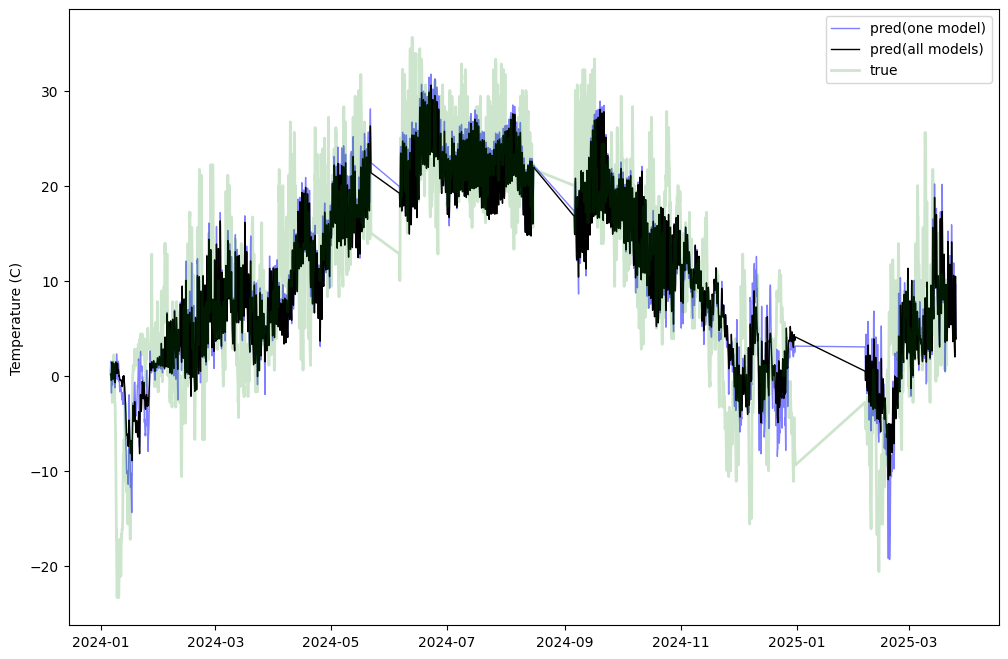

In [136]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.plot(df2.dt_all, df2.pred2, color = 'blue', alpha=0.5, linewidth = 1, label = 'pred(one model)')

plt.plot(df2.dt_all, df2.pred_all, color = 'black', alpha=1, linewidth = 1, label = 'pred(all models)')
plt.plot(df2.shift(120).dt_all, df2.shift(120).true1, color = 'green', alpha = 0.2, linewidth = 2, label = 'true')
plt.ylabel('Temperature (C)')
plt.legend()

In [135]:
df2

,dt_all,pred1,pred2,pred3,pred4,pred5,pred_all,true1
1,2024-01-06 01:00:00,0.703946,1.300679,-0.475154,-0.834864,0.166780,0.172277,0.6
2,2024-01-06 02:00:00,0.782499,1.402089,-0.536018,-0.861708,0.024891,0.162351,0.0
3,2024-01-06 03:00:00,0.815235,1.526356,-0.579987,-0.869068,-0.058034,0.166900,0.6
4,2024-01-06 04:00:00,0.782262,1.531029,-0.609027,-0.870494,-0.198291,0.127096,0.6
5,2024-01-06 05:00:00,0.721137,0.983613,-0.593317,-0.855840,-0.265637,-0.002009,0.6
...,...,...,...,...,...,...,...,...
8926,2025-03-25 20:00:00,5.520691,5.986561,5.697683,5.312307,5.703497,5.644148,9.4
8927,2025-03-25 21:00:00,4.874802,5.460358,5.088749,4.544185,5.204608,5.034540,8.3
8928,2025-03-25 22:00:00,4.333488,5.087883,4.561253,4.046752,4.812275,4.568330,7.2
8929,2025-03-25 23:00:00,3.853867,4.983592,4.141381,3.792142,4.336757,4.221548,6.7


In [54]:
df2.to_csv('preds/test_predALL.csv')

In [ ]:
(df2.pred_all - df2.true1)

In [ ]:
import pathlib, time, torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset   # or your own Dataset
from tqdm import tqdm
import numpy as np
import pandas as pd

# ----------------------------------------------------------------------
# 1. Hyper-parameters & paths
# ----------------------------------------------------------------------
day_extend  = 5
INPUT_DIM   = (day_extend*24+1)*30*1 #5 features(usually *5), 30 id

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f'{DEVICE=}')

train_loader, val_loader = torch.load('../data/dl/train_dl.pth', weights_only=False), torch.load('../data/dl/val_dl.pth', weights_only=False)

def create_model():
    layers = []
    layers = [nn.Linear(INPUT_DIM, 16), nn.ReLU()]
    for _ in range(4):
        layers += [nn.Linear(16, 16), nn.ReLU()]
    layers += [nn.Linear(16, 1)]
    model = nn.Sequential(*layers).to(DEVICE)
    return modelMod

model = create_model()

DEVICE='cpu'


In [81]:
model = create_model()
MAX_EPOCHS  = 100
PATIENCE    = 5

crit = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

best_val   = float("inf")
epochs_bad = 0

for epoch in tqdm(range(1, MAX_EPOCHS + 1)):
    ##### TRAIN #####
    model.train()
    running_loss, n = 0.0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        xb = xb.view(xb.size(0), -1)

        optimizer.zero_grad()
        preds = model(xb).view(-1)
        loss  = crit(preds, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * len(xb)
        n += len(xb)
    train_loss = running_loss / n

    ##### VAL #####
    model.eval()
    running_loss, n = 0.0, 0
    for xb, yb in val_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        xb = xb.view(xb.size(0), -1)
        preds   = model(xb).view(-1)
        loss    = crit(preds, yb)
        running_loss += loss.item() * len(xb)
        n += len(xb)
    val_loss = running_loss / n

    print(f'{train_loss=:.2f}; {val_loss=:.2f}')
    if val_loss < best_val:
        best_val = val_loss
        epochs_bad = 0
        torch.save(model.state_dict(), "model/best_model.pth")

    else:
        epochs_bad += 1
        torch.save(model.state_dict(), f"model/model_epoch{epoch}.pth")
    
    if epochs_bad >= PATIENCE:
        break


  1%|          | 1/100 [00:00<01:10,  1.40it/s]

train_loss=82.28; val_loss=35.17


  2%|▏         | 2/100 [00:01<01:06,  1.47it/s]

train_loss=40.61; val_loss=34.58


  3%|▎         | 3/100 [00:01<01:03,  1.52it/s]

train_loss=39.29; val_loss=33.94


  4%|▍         | 4/100 [00:02<01:04,  1.48it/s]

train_loss=38.42; val_loss=33.59


  5%|▌         | 5/100 [00:03<01:04,  1.47it/s]

train_loss=37.88; val_loss=34.45


  6%|▌         | 6/100 [00:04<01:03,  1.49it/s]

train_loss=37.79; val_loss=33.81


  7%|▋         | 7/100 [00:04<01:02,  1.48it/s]

train_loss=37.46; val_loss=33.59


  8%|▊         | 8/100 [00:05<01:03,  1.46it/s]

train_loss=37.26; val_loss=33.45


  9%|▉         | 9/100 [00:06<01:00,  1.49it/s]

train_loss=37.09; val_loss=33.25


 10%|█         | 10/100 [00:06<00:59,  1.52it/s]

train_loss=36.93; val_loss=33.10


 11%|█         | 11/100 [00:07<00:59,  1.49it/s]

train_loss=36.77; val_loss=32.92


 12%|█▏        | 12/100 [00:08<01:00,  1.46it/s]

train_loss=36.62; val_loss=32.86


 13%|█▎        | 13/100 [00:08<00:59,  1.46it/s]

train_loss=36.50; val_loss=32.68


 14%|█▍        | 14/100 [00:09<00:59,  1.45it/s]

train_loss=36.37; val_loss=32.52


 15%|█▌        | 15/100 [00:10<00:59,  1.44it/s]

train_loss=36.22; val_loss=32.23


 16%|█▌        | 16/100 [00:10<00:57,  1.46it/s]

train_loss=36.10; val_loss=32.13


 17%|█▋        | 17/100 [00:11<00:57,  1.43it/s]

train_loss=35.99; val_loss=32.16


 18%|█▊        | 18/100 [00:12<00:57,  1.41it/s]

train_loss=35.90; val_loss=31.97


 19%|█▉        | 19/100 [00:13<00:56,  1.44it/s]

train_loss=35.81; val_loss=31.91


 20%|██        | 20/100 [00:13<00:55,  1.44it/s]

train_loss=35.69; val_loss=31.88


 21%|██        | 21/100 [00:14<00:55,  1.43it/s]

train_loss=35.63; val_loss=31.85


 22%|██▏       | 22/100 [00:15<00:54,  1.44it/s]

train_loss=35.53; val_loss=31.88


 23%|██▎       | 23/100 [00:15<00:53,  1.45it/s]

train_loss=35.45; val_loss=31.80


 24%|██▍       | 24/100 [00:16<00:53,  1.43it/s]

train_loss=35.38; val_loss=31.75


 25%|██▌       | 25/100 [00:17<00:52,  1.42it/s]

train_loss=35.29; val_loss=31.77


 26%|██▌       | 26/100 [00:17<00:51,  1.44it/s]

train_loss=35.23; val_loss=31.73


 27%|██▋       | 27/100 [00:18<00:50,  1.45it/s]

train_loss=35.17; val_loss=31.70


 28%|██▊       | 28/100 [00:19<00:49,  1.45it/s]

train_loss=35.08; val_loss=31.74


 29%|██▉       | 29/100 [00:19<00:47,  1.49it/s]

train_loss=35.01; val_loss=31.67


 30%|███       | 30/100 [00:20<00:47,  1.47it/s]

train_loss=34.93; val_loss=31.57


 31%|███       | 31/100 [00:21<00:47,  1.47it/s]

train_loss=34.85; val_loss=31.62


 32%|███▏      | 32/100 [00:21<00:45,  1.48it/s]

train_loss=34.82; val_loss=31.61


 33%|███▎      | 33/100 [00:22<00:44,  1.51it/s]

train_loss=34.73; val_loss=31.58


 34%|███▍      | 34/100 [00:23<00:44,  1.48it/s]

train_loss=34.67; val_loss=31.51


 35%|███▌      | 35/100 [00:23<00:44,  1.45it/s]

train_loss=34.60; val_loss=31.49


 36%|███▌      | 36/100 [00:24<00:43,  1.48it/s]

train_loss=34.53; val_loss=31.50


 37%|███▋      | 37/100 [00:25<00:42,  1.49it/s]

train_loss=34.48; val_loss=31.50


 38%|███▊      | 38/100 [00:26<00:42,  1.46it/s]

train_loss=34.41; val_loss=31.45


 39%|███▉      | 39/100 [00:26<00:41,  1.47it/s]

train_loss=34.35; val_loss=31.41


 40%|████      | 40/100 [00:27<00:39,  1.50it/s]

train_loss=34.28; val_loss=31.39


 41%|████      | 41/100 [00:27<00:39,  1.50it/s]

train_loss=34.20; val_loss=31.33


 42%|████▏     | 42/100 [00:28<00:39,  1.45it/s]

train_loss=34.13; val_loss=31.29


 43%|████▎     | 43/100 [00:29<00:39,  1.45it/s]

train_loss=34.06; val_loss=31.25


 44%|████▍     | 44/100 [00:30<00:39,  1.41it/s]

train_loss=34.00; val_loss=31.22


 45%|████▌     | 45/100 [00:30<00:39,  1.41it/s]

train_loss=33.92; val_loss=31.28


 46%|████▌     | 46/100 [00:31<00:37,  1.43it/s]

train_loss=33.87; val_loss=31.22


 47%|████▋     | 47/100 [00:32<00:37,  1.43it/s]

train_loss=33.80; val_loss=31.19


 48%|████▊     | 48/100 [00:32<00:36,  1.44it/s]

train_loss=33.73; val_loss=31.12


 49%|████▉     | 49/100 [00:33<00:35,  1.42it/s]

train_loss=33.67; val_loss=31.10


 50%|█████     | 50/100 [00:34<00:35,  1.42it/s]

train_loss=33.62; val_loss=31.08


 51%|█████     | 51/100 [00:35<00:35,  1.39it/s]

train_loss=33.56; val_loss=31.06


 52%|█████▏    | 52/100 [00:35<00:34,  1.41it/s]

train_loss=33.52; val_loss=31.10


 53%|█████▎    | 53/100 [00:36<00:32,  1.44it/s]

train_loss=33.47; val_loss=31.02


 54%|█████▍    | 54/100 [00:37<00:32,  1.42it/s]

train_loss=33.41; val_loss=31.02


 55%|█████▌    | 55/100 [00:37<00:32,  1.40it/s]

train_loss=33.37; val_loss=31.00


 56%|█████▌    | 56/100 [00:38<00:30,  1.42it/s]

train_loss=33.30; val_loss=31.00


 57%|█████▋    | 57/100 [00:39<00:30,  1.41it/s]

train_loss=33.27; val_loss=31.00


 58%|█████▊    | 58/100 [00:40<00:30,  1.39it/s]

train_loss=33.20; val_loss=30.98


 59%|█████▉    | 59/100 [00:40<00:29,  1.41it/s]

train_loss=33.17; val_loss=30.99


 60%|██████    | 60/100 [00:41<00:28,  1.42it/s]

train_loss=33.11; val_loss=30.96


 61%|██████    | 61/100 [00:42<00:28,  1.39it/s]

train_loss=33.07; val_loss=30.95


 62%|██████▏   | 62/100 [00:42<00:27,  1.40it/s]

train_loss=33.01; val_loss=30.96


 63%|██████▎   | 63/100 [00:43<00:26,  1.42it/s]

train_loss=32.96; val_loss=30.93


 64%|██████▍   | 64/100 [00:44<00:26,  1.38it/s]

train_loss=32.92; val_loss=30.91


 65%|██████▌   | 65/100 [00:45<00:25,  1.39it/s]

train_loss=32.87; val_loss=30.90


 66%|██████▌   | 66/100 [00:45<00:23,  1.43it/s]

train_loss=32.84; val_loss=30.96


 67%|██████▋   | 67/100 [00:46<00:22,  1.45it/s]

train_loss=32.79; val_loss=30.95


 68%|██████▊   | 68/100 [00:47<00:22,  1.43it/s]

train_loss=32.74; val_loss=30.92


 69%|██████▉   | 69/100 [00:47<00:21,  1.44it/s]

train_loss=32.69; val_loss=30.93


 69%|██████▉   | 69/100 [00:48<00:21,  1.42it/s]

train_loss=32.64; val_loss=30.93
